# Cheat sheet for seaborn

Recently upgraded for version 11.0.0. There might be many cool plots from this version not yet covered here!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
from IPython.display import display_html
from IPython.display import display
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline; border:0px"')          
    display_html(html_str,raw=True)
np.random.seed(1)
print("seaborn version {}".format(sns.__version__))
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

seaborn version 0.11.0


<h2>Kernel density plot</h2>

### kdeplot

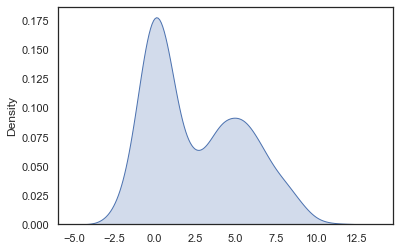

In [2]:
df = pd.DataFrame([
    np.random.normal(0,1,1000)
    ,np.random.normal(5,2,1000)       
])
df = df.T
df.columns = ['first', 'second']
v3 = np.concatenate((df['first'], df['second']))
fig = plt.figure()
ax = fig.add_subplot(111)
_ = sns.kdeplot(v3, shade = True, ax = ax)

### distplot
Combination of histogram and kde plot

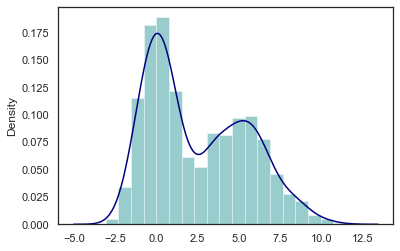

In [3]:
df = pd.DataFrame([
    np.random.normal(0,1,1000)
    ,np.random.normal(5,2,1000)       
])
df = df.T
df.columns = ['first', 'second']
v3 = np.concatenate((df['first'], df['second']))
fig = plt.figure()
ax = fig.add_subplot(111)
_ = sns.distplot(v3, hist_kws = {'color': 'Teal'}, kde_kws = {'color': 'Navy'}, ax = ax)


### Ridge plot

Modification of [this](https://seaborn.pydata.org/examples/kde_ridgeplot).

In [4]:
# Create the data
x = np.random.RandomState(1979).randn(500)
groups = list("ABCDEFGHIJ")
g = np.tile(groups, 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m
date_mapping = dict(zip(groups, pd.date_range('2006-01-01', periods=len(groups), freq='1A')))
df["period"] = df["g"].map(date_mapping)
del df["g"]
df.head(3)

x     period
0  64.038123 2006-12-31
1  66.147050 2007-12-31
2  66.370011 2008-12-31

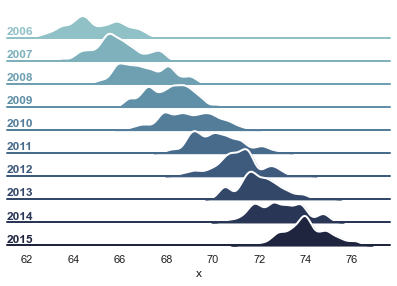

In [5]:
# Initialize the FacetGrid object
group_col = "period"
df[group_col] = df[group_col].dt.strftime("%Y")

pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row=group_col, hue=group_col, aspect=15, height=0.4, palette=pal)

# Draw the densities in a few steps
g.map(
    sns.kdeplot,
    "x",
    bw_adjust=.5,
    clip_on=False,
    fill=True,
    alpha=1,
    linewidth=1.5
)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)
g.map(label, "x")
g.fig.subplots_adjust(hspace=-.25)
g.set_titles("")
g.set(yticks=[])
_ = g.despine(bottom=True, left=True)

<h2>Different joint plots</h2>

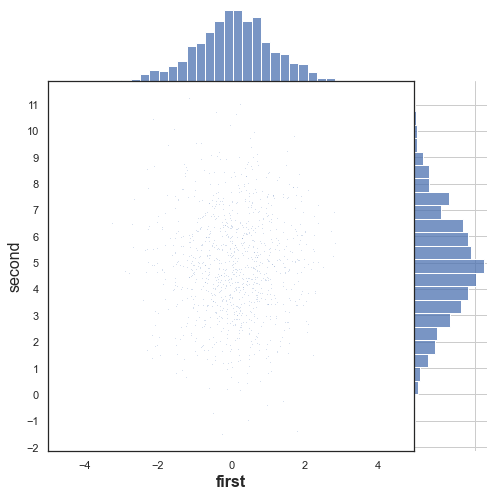

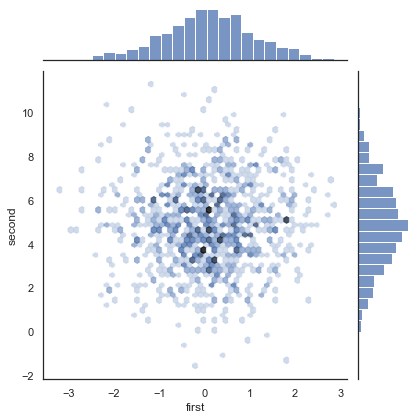

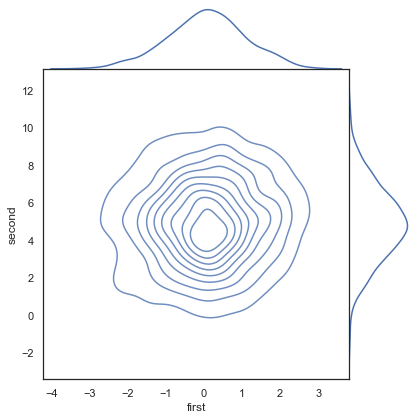

In [6]:
# Seaborn joint plot is a figure level function, resulting in a seaborn
# grid object that cannot be passed into axes of existing figure
df = pd.DataFrame([
    np.random.normal(0,1,1000)
    ,np.random.normal(5,2,1000)       
])
df = df.T
df.columns = ['first', 'second']

# Normal joint plot
grid = sns.jointplot(df['first'],df['second'], alpha = 0.3, height = 7, joint_kws={'s':1}, space = 0)

# access and tweak grid subplots 
#grid.ax_joint.set_aspect('equal')
grid.set_axis_labels('x', 'second', fontsize=16)
grid.ax_joint.set_xlabel('first', fontweight='bold')
grid.ax_marg_x.set_xlim((-5,5))
grid.ax_joint.locator_params(axis='y', nbins=15)

# twek marginal hist plots
grid.ax_marg_y.grid('on')

# Hex plot
grid2 = sns.jointplot(df['first'],df['second'], alpha = 0.8, kind = 'hex', joint_kws = {'gridsize':50})

# kde joint plot
grid3 = sns.jointplot(df['first'],df['second'], alpha = 0.8, kind = 'kde', space = 0)

#### Overblown example with adjusted settings

Outdated in version 11.0.0.

In [7]:
#df = pd.DataFrame([
#    np.random.normal(0,1,1000)
#    ,np.random.normal(5,2,1000)       
#])
#df = df.T
#df.columns = ['first', 'second']
## Normal joint plot
#grid = sns.jointplot(df['first'],df['second'], alpha = 0.3, height = 7, joint_kws={'s':4}, space = 0,
#                     marginal_kws={'kde':True, 'hist':False,'kde_kws':{'shade':True}})
#plt.subplots_adjust(top=0.9)
#grid.fig.suptitle('Title')

### Jointplot with hue
There is no official solution for jointplot with hue. However, there is this attempt: https://gist.github.com/ruxi/ff0e9255d74a3c187667627214e1f5fa

This still seems to have some problems with marginali distribution alignment unfortunately... At least when values are lumped t the very end point.

In [8]:
def jointplot_w_hue(data, x, y, hue=None, colormap = None, 
                    figsize = None, fig = None, scatter_kws=None):
    """https://gist.github.com/ruxi/ff0e9255d74a3c187667627214e1f5fa"""
    
    import matplotlib.gridspec as gridspec
    import matplotlib.patches as mpatches
    
    #defaults
    if colormap is None:
        colormap = sns.color_palette() #['blue','orange']
    if figsize is None:
        figsize = (5,5)
    if fig is None:
        fig  = plt.figure(figsize = figsize)
    if scatter_kws is None:
        scatter_kws = dict(alpha=0.4, lw=1)
        
    # derived variables
    if hue is None:
        return "use normal sns.jointplot"
    hue_groups = data[hue].unique()

    subdata = dict()
    colors = dict()
    
    active_colormap = colormap[0: len(hue_groups)]
    legend_mapping = []
    for hue_grp, color in zip(hue_groups, active_colormap):
        legend_entry = mpatches.Patch(color=color, label=hue_grp)
        legend_mapping.append(legend_entry)
        
        subdata[hue_grp] = data[data[hue]==hue_grp]
        colors[hue_grp] = color
        
    # canvas setup
    grid = gridspec.GridSpec(2, 2,
                           width_ratios=[4, 1],
                           height_ratios=[1, 4],
                           hspace = 0, wspace = 0
                           )
    ax_main    = plt.subplot(grid[1,0])
    ax_xhist   = plt.subplot(grid[0,0], sharex=ax_main)
    ax_yhist   = plt.subplot(grid[1,1])#, sharey=ax_main)
    
    ## plotting
   
    # histplot x-axis
    for hue_grp in hue_groups:
        sns.distplot(subdata[hue_grp][x], color = colors[hue_grp]
                     , ax = ax_xhist)

    # histplot y-axis
    for hue_grp in hue_groups:
        sns.distplot(subdata[hue_grp][y], color = colors[hue_grp]
                     , ax = ax_yhist, vertical=True) 

    # main scatterplot 
    # note: must be after the histplots else ax_yhist messes up
    for hue_grp in hue_groups:
        sns.regplot(data = subdata[hue_grp], fit_reg=False,
                    x = x, y = y, ax = ax_main, color = colors[hue_grp]
                    , scatter_kws=scatter_kws
                   )        
        
    # despine
    for myax in [ax_yhist, ax_xhist]:
        sns.despine(ax = myax, bottom=False, top=True, left = False, right = True
                    , trim = False)
        plt.setp(myax.get_xticklabels(), visible=False)
        plt.setp(myax.get_yticklabels(), visible=False)
    
    
    # topright 
    ax_legend   = plt.subplot(grid[0,1])#, sharey=ax_main)
    plt.setp(ax_legend.get_xticklabels(), visible=False)
    plt.setp(ax_legend.get_yticklabels(), visible=False)

    ax_legend.legend(handles=legend_mapping)
    plt.close()
    return dict(fig = fig, gridspec = grid)

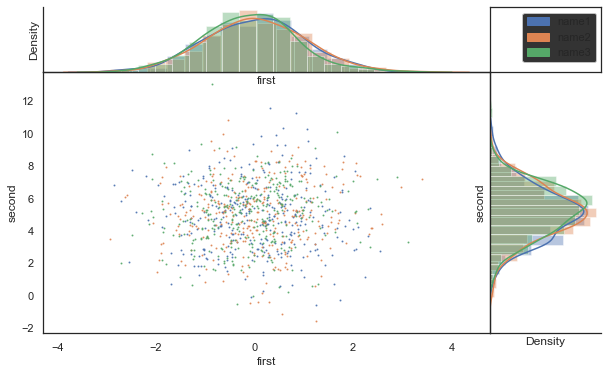

In [9]:
plt.close("all")
df = pd.DataFrame([
     np.random.normal(0,1,1000)
    ,np.random.normal(5,2,1000)
    ,np.random.normal(-2,8,1000)    
])
df = df.T
df['name'] = ['name1']*333 + ['name2']*333 + ['name3']*334
df.columns = ['first', 'second', 'third','name']

jointplot_w_hue(data=df, x = 'first', y = 'second', hue = 'name', figsize = (10,6)
               ,scatter_kws= {'s':1}
               )['fig']

### Two jointplots next to each other

In [10]:
def two_pair_plots(dataf,**kwargs):
    height      = kwargs.get('height', 12)
    ylim1       = kwargs.get('ylim1', None)            
    ylim2       = kwargs.get('ylim2', None)
    
    xlim1       = kwargs.get('xlim1', None)            
    xlim2       = kwargs.get('xlim2', None)    
    
    kind1       = kwargs.get('kind1', "scatter")
    kind2       = kwargs.get('kind2', "scatter")
    alpha1      = kwargs.get('alpha1', 0.3)
    alpha2      = kwargs.get('alpha2', 0.3)
        
    # hack to supress joint plots
    %matplotlib notebook
    plt.ioff()

    # hack to get JointGrids next to eachother
    # https://stackoverflow.com/questions/35042255/how-to-plot-multiple-seaborn-jointplot-in-subplot
    JG1 = sns.jointplot(dataf.iloc[:,0], dataf.iloc[:,1], kind = kind1, alpha = alpha1, height = height)
    JG2 = sns.jointplot(dataf.iloc[:,0], dataf.iloc[:,1], kind = kind2, alpha = alpha2, height = height)

    if ylim1 is not None:
        JG1.ax_marg_x.set_xlim(xlim1)    
    if xlim2 is not None:
        JG2.ax_marg_x.set_xlim(xlim2)
        
    if ylim1 is not None:
        JG1.ax_marg_y.set_ylim(ylim1)    
    if ylim2 is not None:
        JG2.ax_marg_y.set_ylim(ylim2)

    %matplotlib inline
    f = plt.figure()
    for J in [JG1, JG2]:
        for A in J.fig.axes:
            f._axstack.add(f._make_key(A), A)

    #subplots size adjustment
    f.axes[0].set_position([0.05, 0.05, 0.4,  0.4])
    f.axes[1].set_position([0.05, 0.45, 0.4,  0.05])
    f.axes[2].set_position([0.45, 0.05, 0.05, 0.4])
    f.axes[3].set_position([0.55, 0.05, 0.4,  0.4])
    f.axes[4].set_position([0.55, 0.45, 0.4,  0.05])
    f.axes[5].set_position([0.95, 0.05, 0.05, 0.4])    
    

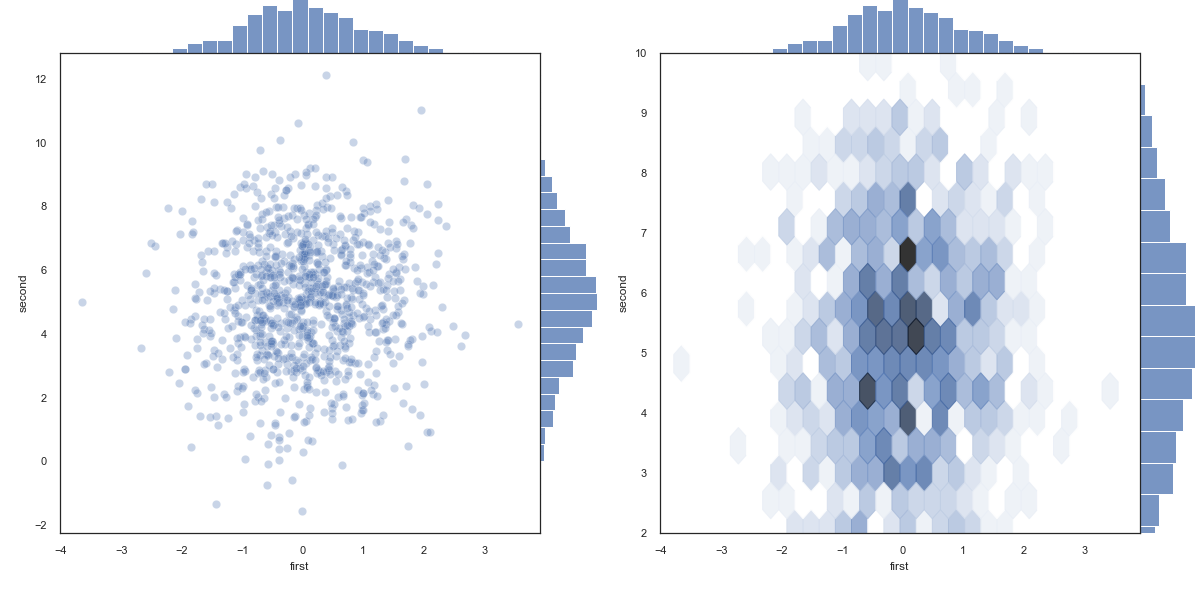

In [11]:
df = pd.DataFrame([
    np.random.normal(0,1,1000)
    ,np.random.normal(5,2,1000)       
])
df = df.T
df.columns = ['first', 'second']
two_pair_plots(df, ylim2 = (2,10), kind2 = 'hex', alpha2 = 0.8)

## Joint plots with hue (loses edge distributions) 

### categorical hue, simple one plot

first    second     third   name
0  1.351321  5.482103  1.113628  name1
1 -0.348350  7.224510 -2.841714  name1
2 -0.062201  5.070384 -3.549421  name1
3  0.184909  3.801593 -8.470678  name1
4 -0.385953  7.525015 -8.923649  name1

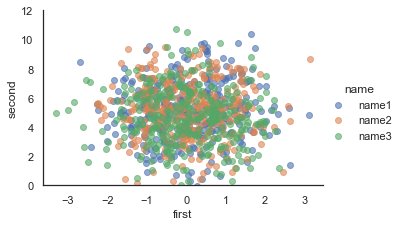

In [12]:
df = pd.DataFrame([
     np.random.normal(0,1,1000)
    ,np.random.normal(5,2,1000)
    ,np.random.normal(-2,8,1000)    
])
df = df.T
df['name'] = ['name1']*333 + ['name2']*333 + ['name3']*334
df.columns = ['first', 'second', 'third','name']
display(df.head())

g = sns.lmplot(x='first', y='second', hue='name', data=df, fit_reg=False, height=3, aspect=1.5, scatter_kws = {'alpha': 0.6})
g.axes[0,0].set_ylim((0,12))
gg = g.ax.legend

### categorical hue, two plots

In [13]:
def two_lm_plots(dataf1,dataf2,names1,names2,**kwargs):
    """
    Plots two lmplots in same figure.
    Still needs work as sizing does not work as it should!
    """
    #height      = kwargs.get('height', 7)
    #aspect      = kwargs.get('aspect', 1.5)    
    ylim1       = kwargs.get('ylim1', None)            
    ylim2       = kwargs.get('ylim2', None)
    
    xlim1       = kwargs.get('xlim1', None)            
    xlim2       = kwargs.get('xlim2', None)    
    
    alpha1      = kwargs.get('alpha1', 0.5)
    alpha2      = kwargs.get('alpha2', 0.5)
        
    # hack to supress joint plots
    %matplotlib notebook
    plt.ioff()

    # hack to get JointGrids next to eachother
    g1 = sns.lmplot(x=names1['x'], y=names1['y'], hue=names1['hue'], height = 6, aspect = 1.2
                     ,data=dataf1,fit_reg=False, scatter_kws = {'alpha': alpha1})
    
    g2 = sns.lmplot(x=names2['x'], y=names2['y'], hue=names2['hue'], height = 6, aspect = 1.2
                     ,data=dataf2,fit_reg=False, scatter_kws = {'alpha': alpha2})
        
    %matplotlib inline
    f = plt.figure()
    for J in [g1,g2]:
        for A in J.fig.axes:
            f._axstack.add(f._make_key(A), A)

    #subplots size adjustment
    f.axes[0].set_position([0.1, 0.1, 0.9,  0.35])
    f.axes[1].set_position([0.1, 0.55, 0.9,  0.35])
    
    f.axes[0].set_xlim(xlim1)
    f.axes[0].set_ylim(ylim1)
    f.axes[1].set_xlim(xlim2)
    f.axes[1].set_ylim(xlim2)    
    
    #f.axes[0].legend()
    f.axes[1].legend()    
    

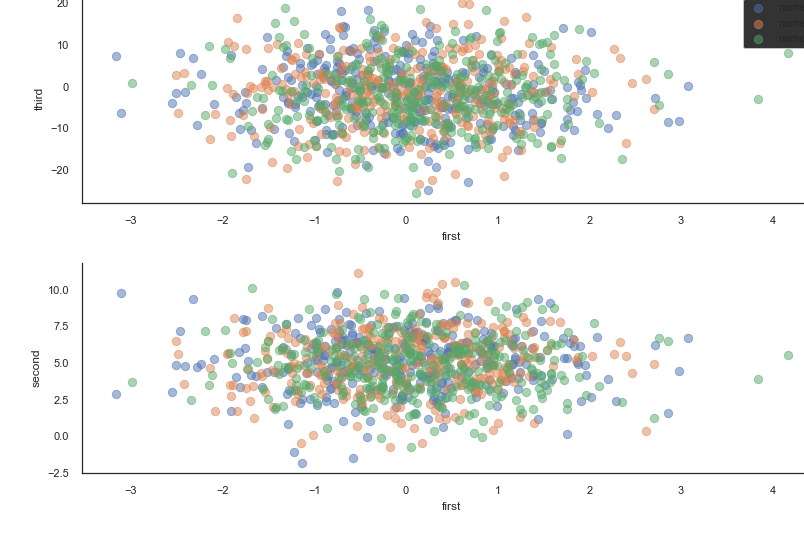

In [14]:
df = pd.DataFrame([
     np.random.normal(0,1,1000)
    ,np.random.normal(5,2,1000)
    ,np.random.normal(-2,8,1000)    
])
df = df.T
df['name'] = ['name1']*333 + ['name2']*333 + ['name3']*334
df.columns = ['first', 'second', 'third','name']

df_plot1 = df[['first','second','name']].copy()
names1 = {'x':'first','y':'second','hue':'name'}

df_plot2 = df[['first','third','name']].copy()
names2 = {'x':'first','y':'third','hue':'name'}

two_lm_plots(df_plot1,df_plot2,names1,names2)

### continuous hue

first    second     third   name
0  1.337838 -1.408129  1.587159  name1
1 -1.529945  4.064927  1.678795  name1
2 -0.499657  4.480940 -1.777851  name1
3  0.253648  6.781568 -1.091155  name1
4 -0.054476  5.714915 -6.549249  name1

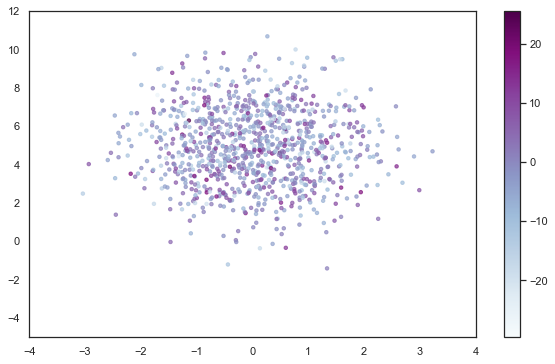

In [15]:
df = pd.DataFrame([
     np.random.normal(0,1,1000)
    ,np.random.normal(5,2,1000)
    ,np.random.normal(-2,8,1000)    
])
df = df.T
df['name'] = ['name1']*333 + ['name2']*333 + ['name3']*334
df.columns = ['first', 'second', 'third','name']
display(df.head())

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
#cm = plt.cm.get_cmap('RdYlBu')
cm = plt.cm.get_cmap('BuPu')
sc = ax.scatter(df['first'], df['second'], c=df['third'], vmin = df['third'].min(), vmax=df['third'].max(), s=12, cmap=cm, alpha = 0.7)
ax.set_xlim(-4,4)
ax.set_ylim(-5,12)
color_bar = plt.colorbar(sc)
color_bar.set_alpha(1) # force color bar alpha = 1
color_bar.draw_all()


<h2>Pair plot</h2>

first    second      third   name
0 -1.931564  6.073285   2.188869  name1
1 -0.160426  5.306396   8.270968  name1
2 -0.832220 -0.156540   1.782579  name1
3 -0.206112  4.574058   7.948214  name1
4  1.026255  4.584010 -18.669246  name1

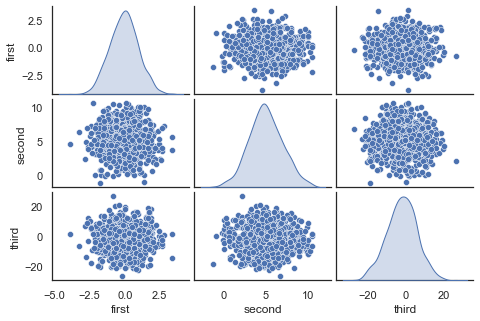

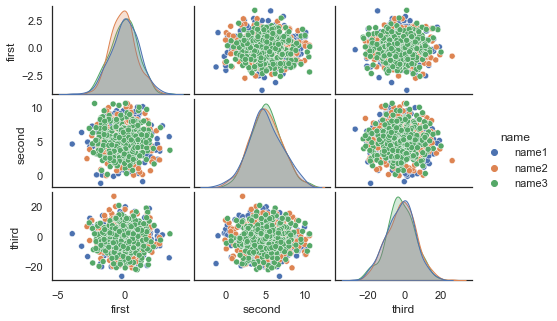

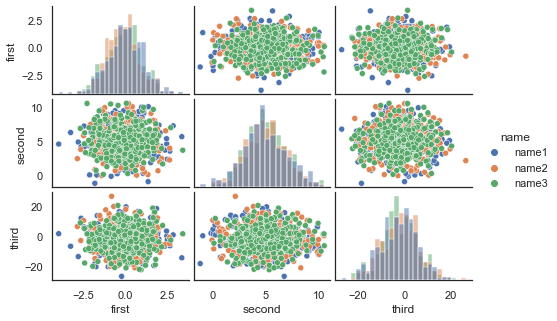

In [16]:
df = pd.DataFrame([
     np.random.normal(0,1,1000)
    ,np.random.normal(5,2,1000)
    ,np.random.normal(-2,8,1000)    
])
df = df.T
df['name'] = ['name1']*333 + ['name2']*333 + ['name3']*334
df.columns = ['first', 'second', 'third','name']
display(df.head())

fig3 = sns.pairplot(df, diag_kind = 'kde', height=1.5, aspect=1.5)
plt.show()

fig1 = sns.pairplot(df, hue = 'name', height=1.5, aspect=1.5)
plt.show()

fig2 = sns.pairplot(df, hue = 'name', diag_kind = 'hist', height=1.5, aspect=1.5)


<h2>Box/violin/swarm plots</h2>

total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4

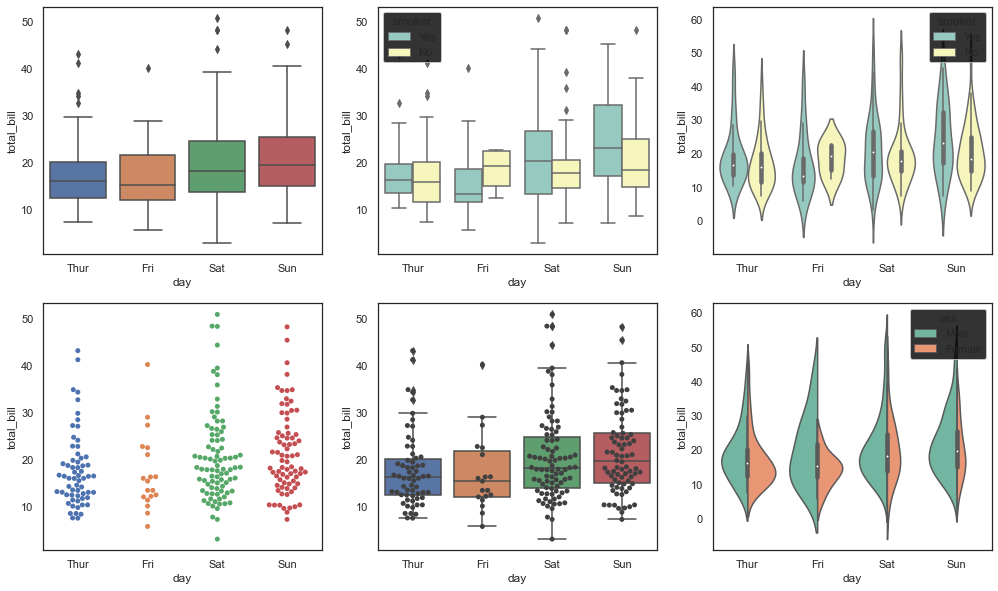

In [17]:
tips = sns.load_dataset("tips")
display(tips.head())

fig, axes = plt.subplots(nrows = 2, ncols = 3)
fig.set_size_inches(17, 10)

sns.boxplot(x = "day", y = "total_bill", data = tips, ax = axes[0,0])
sns.boxplot(x = "day", y = "total_bill", hue = "smoker", data = tips, ax = axes[0,1], palette = 'Set3')
sns.violinplot(x = "day", y = "total_bill", hue = "smoker", data = tips, ax = axes[0,2], palette = 'Set3')
sns.swarmplot(x = "day", y = "total_bill", data = tips, ax = axes[1,0])
sns.boxplot(x = "day", y = "total_bill", data = tips, ax = axes[1,1])
sns.swarmplot(x = "day", y = "total_bill", data = tips, color=".25", ax = axes[1,1])
_ = sns.violinplot(x="day", y="total_bill", hue="sex",data=tips, palette="Set2", split=True,scale="count", ax = axes[1,2])

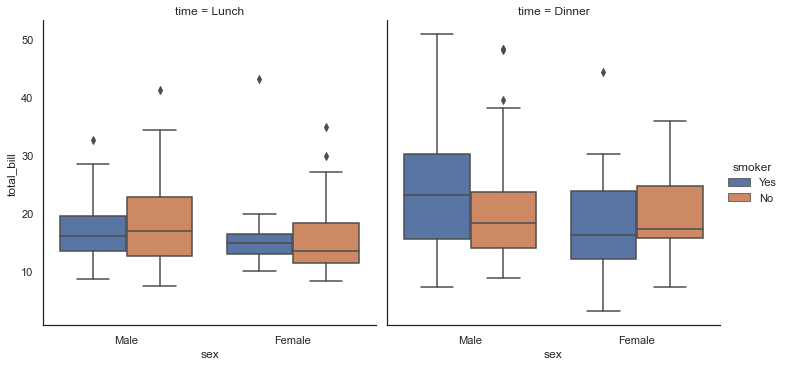

In [18]:
_ = sns.factorplot(x="sex", y="total_bill",hue="smoker", col="time",data=tips, kind="box")

<h2>Facet grids</h2>

total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4

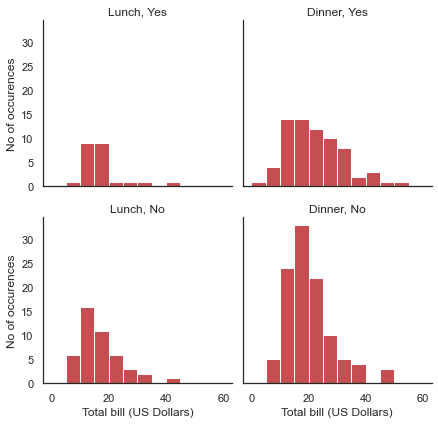

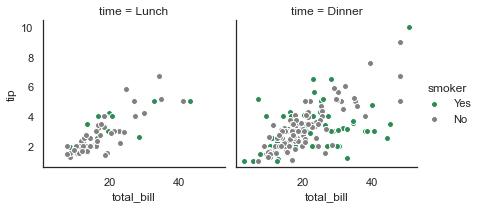

In [19]:
tips = sns.load_dataset("tips")
display(tips.head())

bins = np.arange(0, 65, 5)
g = sns.FacetGrid(tips, col = "time", row = "smoker", size = 3, aspect = 1)
g = (g.map(plt.hist, "total_bill", color = 'r', bins = bins)
        .set_titles("{col_name}, {row_name}")
        .set_axis_labels("Total bill (US Dollars)", "No of occurences")
    )

pal = dict(Yes = "seagreen", No = "gray")
g2 = sns.FacetGrid(tips, col = "time",  hue = "smoker", palette = pal)
g2 = (g2.map(plt.scatter, "total_bill", "tip", edgecolor="w")
          .add_legend())

<h2>Reg plot</h2>

total_bill   tip     sex smoker  day    time  size sex_bin
0       16.99  1.01  Female     No  Sun  Dinner     2       0
1       10.34  1.66    Male     No  Sun  Dinner     3       1
2       21.01  3.50    Male     No  Sun  Dinner     3       1
3       23.68  3.31    Male     No  Sun  Dinner     2       1
4       24.59  3.61  Female     No  Sun  Dinner     4       0

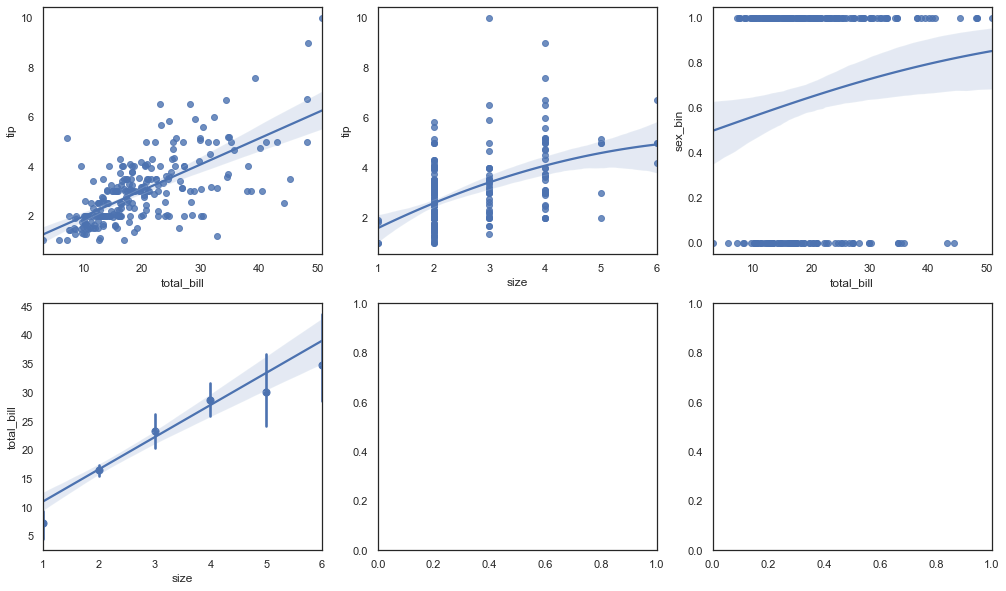

In [20]:
tips = sns.load_dataset("tips")
mapping = {'Female':0, 'Male':1}
tips['sex_bin'] = tips['sex'].map(mapping)
display(tips.head())

fig, axes = plt.subplots(nrows = 2, ncols = 3)
fig.set_size_inches(17, 10)

p1 = sns.regplot(x = "total_bill", y = "tip", data = tips, ci = 95, ax = axes[0,0])
sns.regplot(x = "size", y = "tip", order = 2, data = tips, ci = 95, ax = axes[0,1])
sns.regplot(x = "total_bill", y = "sex_bin", data = tips, logistic = True, ax = axes[0,2])
_ = sns.regplot(x = "size", y = "total_bill", data = tips, x_estimator = np.mean, ax = axes[1,0])

In [21]:
# Sometimes we might want to calculate the slope results from regplot
# Seaborn does not automatically proveide this, but we can do it ourselves
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(x = p1.get_lines()[0].get_xdata(), y = p1.get_lines()[0].get_ydata())
print('Slope = {0:.3f}, intercept = {1:.3f}, p_val = {2:.3f}'.format(slope, intercept, p_value))

Slope = 0.105, intercept = 0.920, p_val = 0.000


<h2>lmplot</h2>
This function combines regplot() and FacetGrid. It is intended as a convenient interface to fit regression models across conditional subsets of a dataset.

sepal_length 
 sepal_width 
 petal_length 
 petal_width 
 species 
 
 
 
 
 0 
 5.1 
 3.5 
 1.4 
 0.2 
 setosa 
 
 
 1 
 4.9 
 3.0 
 1.4 
 0.2 
 setosa 
 
 
 2 
 4.7 
 3.2 
 1.3 
 0.2 
 setosa 
 
 
 3 
 4.6 
 3.1 
 1.5 
 0.2 
 setosa 
 
 
 4 
 5.0 
 3.6 
 1.4 
 0.2 
 setosa 
 
 
 
 
 
 
 total_bill 
 tip 
 sex 
 smoker 
 day 
 time 
 size 
 
 
 
 
 0 
 16.99 
 1.01 
 Female 
 No 
 Sun 
 Dinner 
 2 
 
 
 1 
 10.34 
 1.66 
 Male 
 No 
 Sun 
 Dinner 
 3 
 
 
 2 
 21.01 
 3.50 
 Male 
 No 
 Sun 
 Dinner 
 3 
 
 
 3 
 23.68 
 3.31 
 Male 
 No 
 Sun 
 Dinner 
 2 
 
 
 4 
 24.59 
 3.61 
 Female 
 No 
 Sun 
 Dinner 
 4

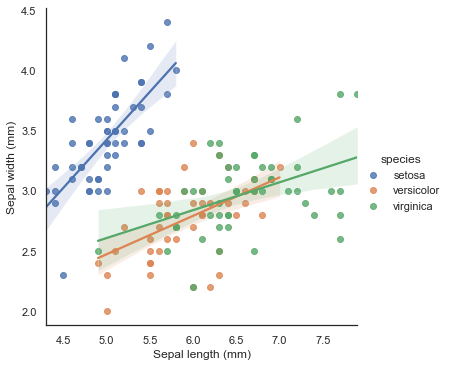

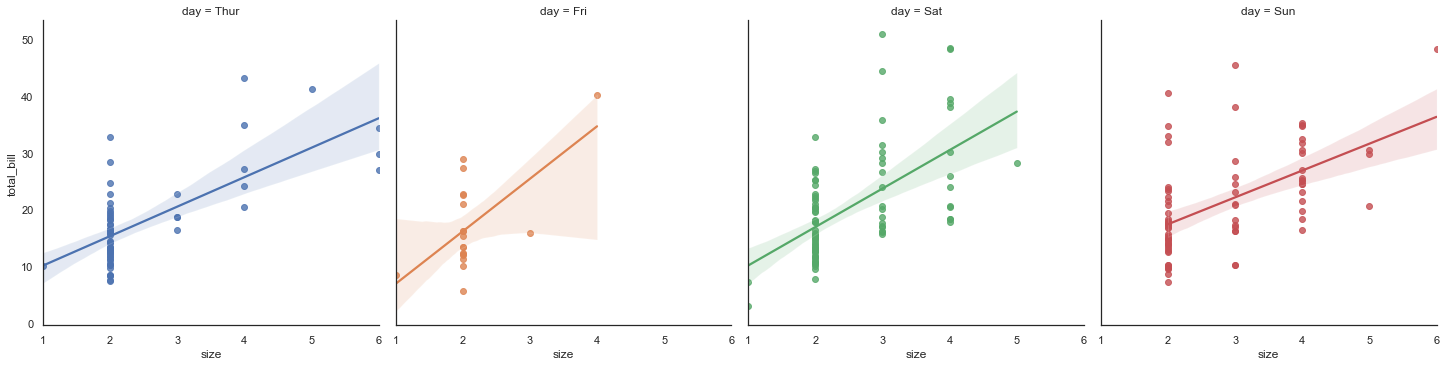

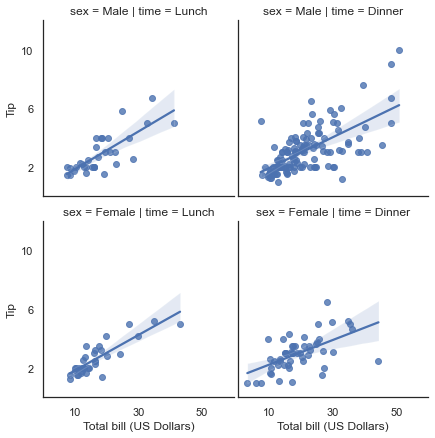

In [22]:
iris = sns.load_dataset("iris")
tips = sns.load_dataset("tips")

display_side_by_side(iris.head(), tips.head())

g = sns.lmplot(x = "sepal_length", y = "sepal_width", data = iris, hue = "species", truncate = True, size = 5)
g.set_axis_labels("Sepal length (mm)", "Sepal width (mm)")

g2 = sns.lmplot(x = "size", y = "total_bill",data = tips, col = "day", hue = "day", col_wrap = 4) # remove hue for same color

g3 = sns.lmplot(x = "total_bill", y = "tip", row = "sex", col = "time", data = tips, size = 3)
g3 = (g3.set_axis_labels("Total bill (US Dollars)", "Tip")
        .set(xlim = (0, 60), ylim = (0, 12), xticks = [10, 30, 50], yticks = [2, 6, 10])
        .fig.subplots_adjust(wspace = 0.02))

## Heat map

<AxesSubplot:>

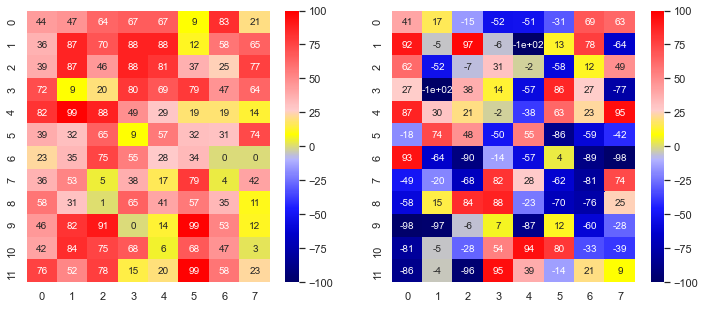

In [23]:
np.random.seed(0)
import matplotlib.colors as mcolors

x1 = np.random.randint(0,100,size=(12,8))
x2 = np.random.randint(-100,100,size=(12,8))

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)

cmap = mcolors.LinearSegmentedColormap.from_list("n",['#000066','#000099','#0000cc','#1a1aff','#6666ff','#b3b3ff',
                       '#ffff00','#ffcccc','#ff9999','#ff6666','#ff3333','#ff0000'])
norm = plt.Normalize(-100,100)

sns.heatmap(x1, ax=axes[0], cmap=cmap, norm=norm, annot=True)
sns.heatmap(x2, ax=axes[1], cmap=cmap, norm=norm, annot=True)

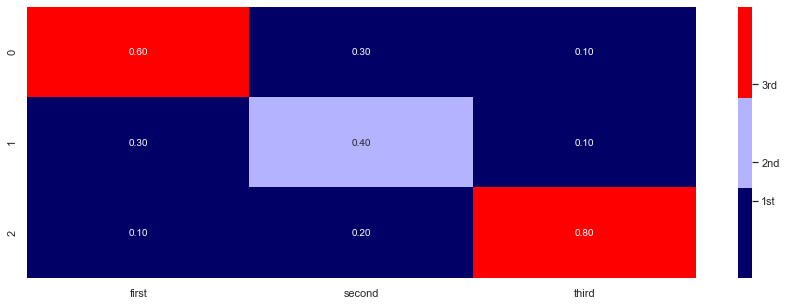

In [24]:
import matplotlib.colors as mcolors

df = pd.DataFrame({'first': [0.6, 0.3, 0.1], 'second': [0.3, 0.4, 0.2], 'third': [0.1,0.1,0.8] })
plt.close('all')
fig = plt.figure()
fig.set_size_inches(15, 5)

cmap = mcolors.LinearSegmentedColormap.from_list("Custom",['#000066','#b3b3ff','#ff0000'],len(df.columns))

ax = sns.heatmap(df, cmap = cmap, annot=True, fmt = '0.2f')
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.3, 0.4, 0.6])
colorbar.set_ticklabels(['1st', '2nd', '3rd'])

## Custom colors from seaborn palette

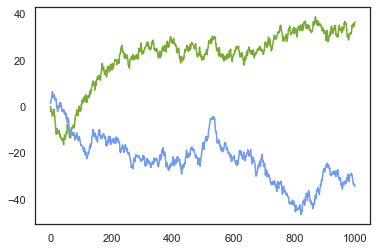

In [25]:
import matplotlib.colors as mcolors

# colros
colors = sns.color_palette("husl", 20)
cmap = mcolors.LinearSegmentedColormap.from_list("Custom", colors, len(colors))

# Data
np.random.seed(2525)
x = np.arange(1000)
y1 = np.random.randn(1000).cumsum()
y2 = np.random.randn(1000).cumsum()

# Figure
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.plot(x,y1, label = 'first_line', c = cmap(0.3))
ax1.plot(x,y2, label = 'second_line', c = cmap(0.7))